In [20]:
# Import important Library

# PyTorch for implementing LLM 
import torch

# Neural network modules and functions from PyTorch
from torch import nn
from torch.nn import functional as F

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting Loss etc.
from matplotlib import pyplot as plt

# Time module for tracking execution time
import time

# Pandas for data manipulation and analysis
import pandas as pd

# urllib for handling URL requests (Downloading Dataset)
import urllib.request

In [22]:
# config object for model parameter
MASTER_CONFIG = {
    # Adding parameters later
}

In [21]:
# The URL of the raw text file on GitHub
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# The file name for local storage
file_name = "tinyshakespeare.txt"

# Execute the download
urllib.request.urlretrieve(url, file_name)

('tinyshakespeare.txt', <http.client.HTTPMessage at 0x7f74987262a0>)

In [28]:
# Read the content of the dataset
lines = open("data.txt", 'r').read()

# Create a sorted list of unique characters in the dataset
vocab = sorted(list(set(lines)))

# Display the first 10 characters in the vocabulary list
print('Printing the first 10 characters of the vocab list:', vocab[:10])

# Output the total number of characters in our dataset (Vocabulary Size)
print('Total number of characters in our dataset (Vocabulary Size):', len(vocab))

Printing the first 10 characters of the vocab list: ['\x03', '\n', '\x1a', ' ', '!', '"', '#', '$', '%', '&']
Total number of characters in our dataset (Vocabulary Size): 640


In [29]:
# Mapping integers to characters (itos)
itos = {i: ch for i, ch in enumerate(vocab)}

# Mapping characters to integers (stoi)
stoi = {ch: i for i, ch in enumerate(vocab)}

In [30]:
# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Example: Encode the string "Habari" and then decode the result
decode(encode("Habari"))

'Habari'

In [33]:
# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(lines), dtype=torch.int16)

# Display the shape of the resulting tensor
print(dataset.shape)

torch.Size([58732893])


In [36]:
# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # Split the dataset into training, validation, and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

In [58]:
# Update the MASTER_CONFIG with batch_size and context_window parameters
MASTER_CONFIG.update({
    'batch_size': 8,          # Number of batches to be processed at each random split
    'context_window': 16  ,    # Number of characters in each input (x) and target (y) sequence of each batch
    'vocab_size': len(vocab)
})

In [59]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode the sequences to obtain the corresponding text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# Print the random sample
print(decoded_samples)

[('rugenzi Maendele', 'ugenzi Maendeleo'), ('omosheni mpya na', 'mosheni mpya na '), ('a sura ya mama y', ' sura ya mama ya'), ('itia saini makub', 'tia saini makuba'), ('ia Tanzania, mat', 'a Tanzania, matu'), ('.\nTukio la Mwemb', '\nTukio la Mwembe'), ('ibani mita 40, l', 'bani mita 40, la'), (' lake litakuwa k', 'lake litakuwa ka')]


In [60]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}
    
    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            
            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)
            
            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)
    
    # Set the model back to training mode
    model.train()
    
    return out

In [69]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        
    # Forward pass function for the base model
    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)
        
        # Linear layers for modeling relationships between features
        a = self.linear(x)
        
        # Apply softmax activation to obtain probability distribution
        logits = F.softmax(a, dim=-1)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

        # Print the total number of model parameters
    
        print(f'Model Parameters: {sum([m.numel() for m in self.parameters()])}')
    

In [61]:
# Update MASTER_CONFIG with the dimension of linear layers (128)
MASTER_CONFIG.update({
    'd_model': 128,
})

In [70]:
model = SimpleBrokenModel(MASTER_CONFIG)

model

SimpleBrokenModel(
  (embedding): Embedding(640, 128)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=640, bias=True)
  )
)

In [71]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

In [73]:
# Update MASTER_CONFIG with training parameters
MASTER_CONFIG.update({
    'epochs': 1000,          # Number of training epochs
    'log_interval': 10,      # Log information every 10 batches during training
    'batch_size': 32,        # Increase batch size to 32
})

# Instantiate the SimpleBrokenModel with updated configuration
model = SimpleBrokenModel(MASTER_CONFIG)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(
    model.parameters(),      # Pass the model parameters to the optimizer
)

Validation loss:  6.1494025707244875


<Axes: >

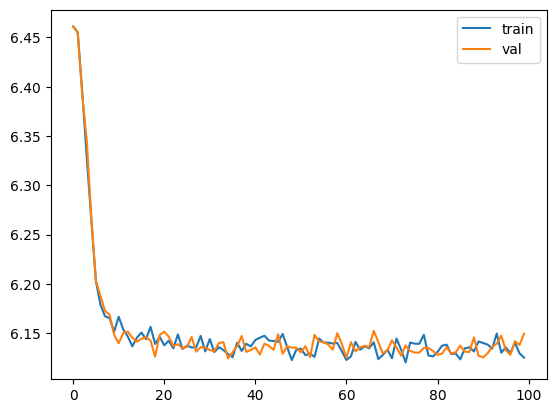

In [77]:
def train(model, optimizer, scheduler=None, config= MASTER_CONFIG, print_logs= False):
    losses = []
    start_time = time.time()
    
    # iterate through epoch 
    for epoch in range (config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logit, loss = model(xs, targets=ys)
        
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
            
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            
            x = evaluate_loss(model)
            
            losses += [x]
            if print_logs:
                print(f'Epoch {epoch} | val loss {x['val']:.3f}')
            
            start_time = time.time()
            
            if scheduler:
                print(f'learning rate = {scheduler.get_lr()}')
                
    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])
    
    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

# Execute the training process
train(model, optimizer)

In [79]:
class SimpleModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )
        
    # Forward pass function for the base model
    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)
        
        logits = self.linear(x)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

        # Print the total number of model parameters
    
        print(f'Model Parameters: {sum([m.numel() for m in self.parameters()])}')
    

Validation loss:  2.3644716262817385


<Axes: >

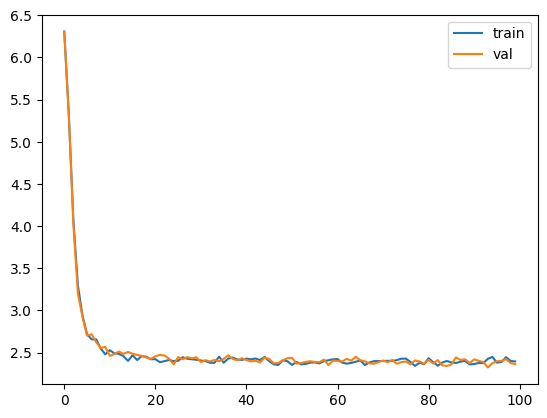

In [85]:
model = SimpleModel(MASTER_CONFIG)

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer)

In [86]:
# Generate function for text generation using the trained model
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

# Generate text using the trained model
generate(model)

['\x03 ha kuhe, huhutivina wamabia j',
 '\x03 ta yara nzanda Ma yafa 37, ka',
 '\x03muralimi kwa kuji wa ke EODONO',
 '\x03 Mona nyabia nate. n. wa muhao',
 '\x03vea ma ynandana yaniatiti Kwa ']